# Clasificación de la anemia en niños menores de 5 años mediante la conjuntiva palpebral

# Carga de los datos

In [65]:
import pickle
import numpy as np

# Cargar el conjunto de datos y las etiquetas usando rutas de cadena sin formato
dataset = pickle.load(open(r'C:\Users\HP\Desktop\ModeloAnemiaConjuntiva\x_final_conjunctiva.pkl', 'rb'))
labels = pickle.load(open(r'C:\Users\HP\Desktop\ModeloAnemiaConjuntiva\y_final_conjunctiva.pkl', 'rb'))


In [66]:
print(dataset.shape)
print(len(labels))

(4272, 160, 160, 3)
4272


# División de datos

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset,  labels, test_size=0.30, random_state=42)

# x_train=x_train/255
# x_test=x_test/255


# Modelado

# EfficientnetV2B0

In [68]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks
my_callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

num_classes = 2

# Load pre-trained EfficientNetV2B0 model without the classification head
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Defining the optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, verbose="auto", validation_split=0.2, callbacks=my_callbacks)

# Saving model
model.save(r"C:\Users\HP\Desktop\ModeloAnemiaConjuntiva\efficientnet_model.h5")

ValueError: object __array__ method not producing an array

In [9]:
model.save_weights(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\efficientnet_model.weights.h5", overwrite=True)


In [14]:
pickle.dump(history, open(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\efficientnetV2B0_history.pkl", 'wb'))

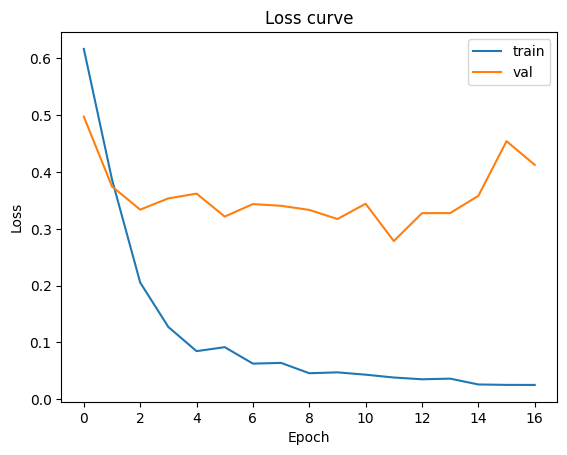

In [15]:
import matplotlib.pyplot as plt
history = pickle.load(open(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\efficientnetV2B0_history.pkl", 'rb'))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.savefig(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\V2B0_Loss_curve.png")
plt.show()


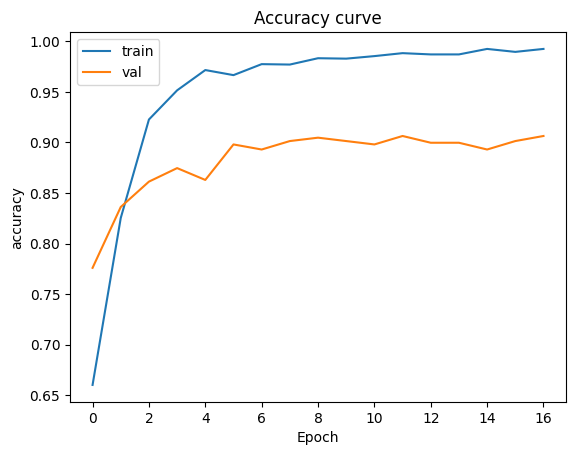

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.savefig(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\V2B0_accuracy_curve.png")
plt.show()



In [20]:
model.load_weights(r"C:\Users\HP\Desktop\Anemia-Detection-From-Conjunctiva\efficientnet_model.h5", skip_mismatch=False, by_name=False)


## Prediction

In [21]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9276 - loss: 0.2533
test loss, test acc: [0.31032833456993103, 0.9157566428184509]


In [22]:
prediction = model.predict(x_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step


## Confusion Matrix

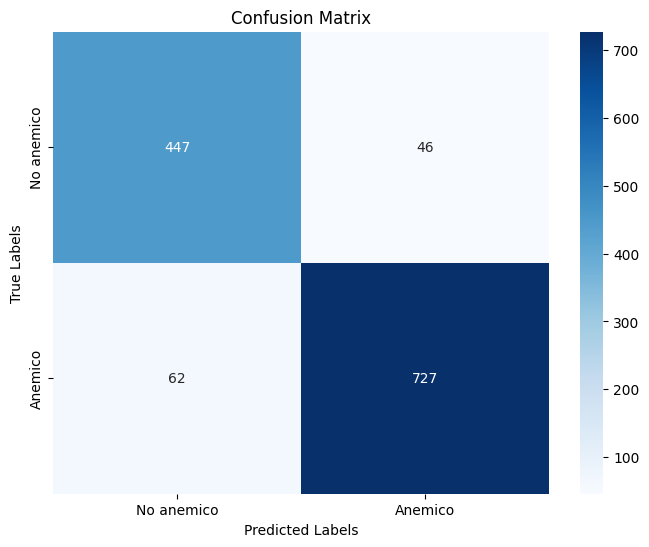

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = np.argmax(prediction, axis=1)

confusion_mat = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No anemico", "Anemico"], yticklabels=["No anemico", "Anemico"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()